# 01 - Data-I/O and featurization

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will cover how to load (and visualize) data with PyEMMA.
We are going to extract different features (collective variables)
and compare how well these are suited for Markov state model building.
Further, we will introduce the concept of streaming data, which is mandatory to work with large data sets.

As with the other notebooks, we employ multiple examples.
The idea is, first, to highlight the fundamental ideas with a non-physical test system (diffusion in a 2D double-well potential)
and, second, to demonstrate real-world applications with molecular dynamics data.

Maintainers: [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
# for visualization of molecular structures:
import nglview
import mdtraj
from threading import Timer

## Case 1: preprocessed data (toy model)

In the most convenient case, we already have preprocessed time series data available in some kind of archive which can be read using numpy:

In [2]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']

print(data)

[[ 0.29565159 -0.65903237]
 [-0.32176688 -1.05838489]
 [ 0.41210344 -1.13569991]
 ...
 [ 0.64046744 -1.62939076]
 [-0.89893827 -0.89200226]
 [ 0.77545152 -0.84004351]]


Here, the archive contains multiple arrays
and we store the array which belongs to the `trajectory` key into the variable `data`.
To see which arrays/keys are available, you can `print` the output of `fh.keys()`.

Please note that mdshare is a package designed for distributing our tutorial data:
the `mdshare.fetch()` call ensures that the file `data/hmm-doublewell-2d-100k.npz` exists
and passes this relative path to the variable `file`.
In practice, we could have written
```Python
file = 'data/hmm-doublewell-2d-100k.npz'
```
provided that this file actually exists.

Once we have the data in memory,
we can use one of PyEMMA's plotting functions to visualize what we have loaded:

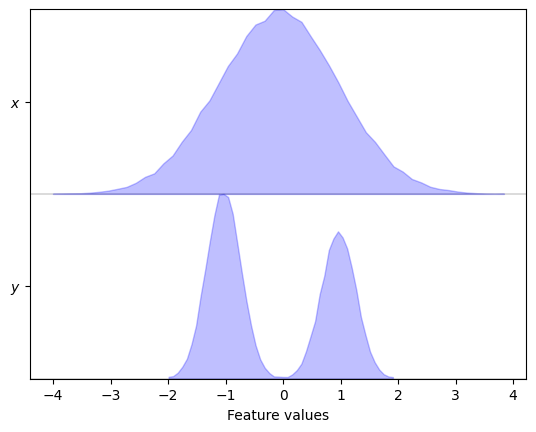

In [3]:
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$']);

The `plot_feature_histograms()` function visualizes the distributions of all degrees of freedom
assuming that the columns of `data` represent different features and the rows represent different time steps.

While `plot_feature_histograms()` can handle arbitrary numbers of features,
we have additional plotting functions for 2D projections.
First, we visualize the sample density in the $x/y$-plane...

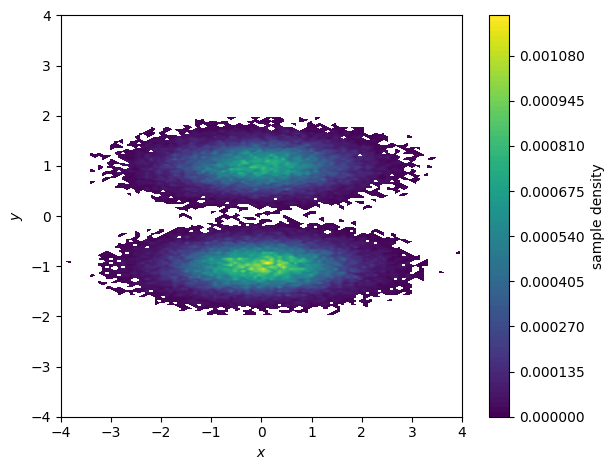

In [4]:
fig, ax, misc = pyemma.plots.plot_density(*data.T)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
fig.tight_layout()

... then, we show the corresponding pseudo free energy surface:

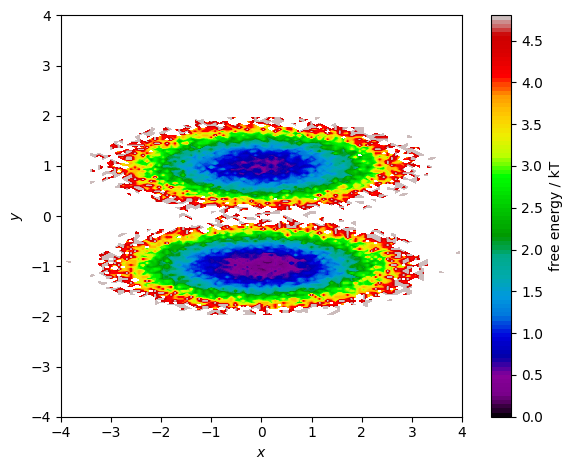

In [5]:
fig, ax, misc = pyemma.plots.plot_free_energy(*data.T, legacy=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
fig.tight_layout()

Both functions make a two-dimensional histogram for the given features;
the free energy surface is defined by the negative logarithm of the probability computed from the histogram counts.

⚠️ Please note that these functions visualize the density and free energy of the **sampled data**,
not the equilibrium distribution of the underlying system.
To account for nonequiblibrium data, you can supply frame-wise weights using the `weights` parameter.
This will be covered in the follow-up [Notebook 04 ➜ 📓](04-msm-analysis.ipynb).

## Case 2: loading `*.xtc` files (alanine dipeptide)

To load molecular dynamics data from one of the standard file formats ( `*.xtc`),
we need not only the actual simulation data, but a topology file, too.
This might differ for other formats though.

In [6]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')
print(pdb)
print(files)

data/alanine-dipeptide-nowater.pdb
['data/alanine-dipeptide-0-250ns-nowater.xtc', 'data/alanine-dipeptide-1-250ns-nowater.xtc', 'data/alanine-dipeptide-2-250ns-nowater.xtc']


We can have a look at the structure with the aid of NGLView.
We load the PDB file into memory with mdtraj and visualize it.
The widget will auto-close after 30 second;
if you want to watch it again, please execute the cell below again.

In PyEMMA, the `featurizer` is a central object that incorporates the system's topology.
We start by creating it using the topology file.
Features are now easily computed by adding the target feature.
If no feature is added, the featurizer will extract Cartesian coordinates.

In [7]:
feat = pyemma.coordinates.featurizer(pdb)

Now we pass the featurizer to the load function to extract the Cartesian coordinates from the trajectory files into memory.
For real world examples one would prefer the `source()` function,
because usually one has more data available than main memory in the workstation.

The warning about **plain coordinates** is triggered,
because these coordinates will include diffusion as a dynamical process,
which might not be what one is interested in.
If the molecule of interest has been aligned to a reference prior the analysis,
it is fine to use these coordinates, but we will see that there are better choices. 

In [8]:
data = pyemma.coordinates.load(files, features=feat)
print('type of data:', type(data))
print('lengths:', len(data))
print('shape of elements:', data[0].shape)
print('n_atoms:', feat.topology.n_atoms)

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/3 [00:00<?, ?it/s]

/opt/Python-3.11.10/lib/python3.11/site-packages/pyemma/coordinates/data/featurization/featurizer.py:896: UserWarning: You have not selected any features. Returning plain coordinates.
  warnings.warn("You have not selected any features. Returning plain coordinates.")


type of data: <class 'list'>
lengths: 3
shape of elements: (250000, 66)
n_atoms: 22


Next, we start adding features which we want to extract from the simulation data.
Here, we want to load the backbone torsions,
because these angles are known to describe all flexibility in the system.
Since this feature is two dimensional, it is also easier to visualize.
Please note that, in complex systems, it is not trivial to visualize plain input features.

In [10]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)

⚠️ Please note that the trajectories have been aligned to a reference structure before.
Since in that case we loose track of the periodic box,
we have to switch off the `periodic` flag for the torsion angle computations.
By default PyEMMA assumes your simulation uses periodic boundary conditions.

We can always call the featurizer's `describe()` method to show which features are requested.
You might have noticed that you can combine arbitrary features by having multiple calls to `add_` methods of the featurizer.

In [11]:
data = pyemma.coordinates.load(files, features=feat)

print('type of data:', type(data))
print('lengths:', len(data))
print('shape of elements:', data[0].shape)

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/3 [00:00<?, ?it/s]

type of data: <class 'list'>
lengths: 3
shape of elements: (250000, 2)


After we have selected all desired features,
we can call the `load()` function to load all features into memory or,
alternatively, the `source()` function to create a streamed feature reader.
For now, we will use `load()`:

In [12]:
print(feat.describe())

['PHI 0 ALA 2', 'PSI 0 ALA 2']


Apparently, we have loaded a list of three two-dimensional `numpy.ndarray` objects from our three trajectory files.
We can visualize these features using the aforementioned plotting functions,
but to do so we have to concatenate the three individual trajectories:

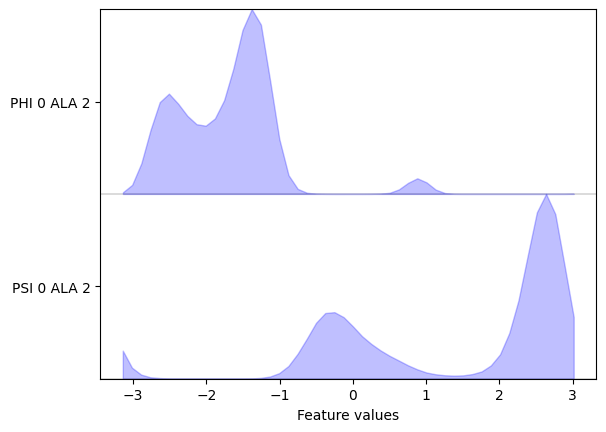

In [13]:
data_concatenated = np.concatenate(data)
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat);

We can now measure the quantity of kinetic variance of the just selected feature by computing a VAMP-2 score <a id="ref-1" href="#cite-vamp-preprint">wu-17</a>.
This enables us to distinguish features on how well they might be suited for MSM building.
The minimum value of this score is $1$, which corresponds to the invariant measure or the observed equilibrium.

With the dimension parameter we specify the amount of dynamic processes that we want to score.
This is of importance later on, when we want to compare different input features
([Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb)).
If we did not fix this number, we would not have an upper bound for the score.

⚠️ Please also note that we split our available data into training and test sets,
where we leave out the last file in training and then use it as test.
This is an important aspect in practice to avoid over-fitting the score.

In [14]:
score_phi_psi = pyemma.coordinates.vamp(data[:-1], dim=2).score(
        test_data=data[-1],
        score_method='VAMP2')
print('VAMP2-score backbone torsions: {:.2f}'.format(score_phi_psi))

VAMP2-score backbone torsions: 1.50


/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)


The score of $1.5$ means that we have the constant of $1$ plus a total contribution of $0.5$ from the other dynamic processes.

We now use PyEMMA's `plot_density()` and `plot_free_energy()` functions to create Ramachandran plots of our system:

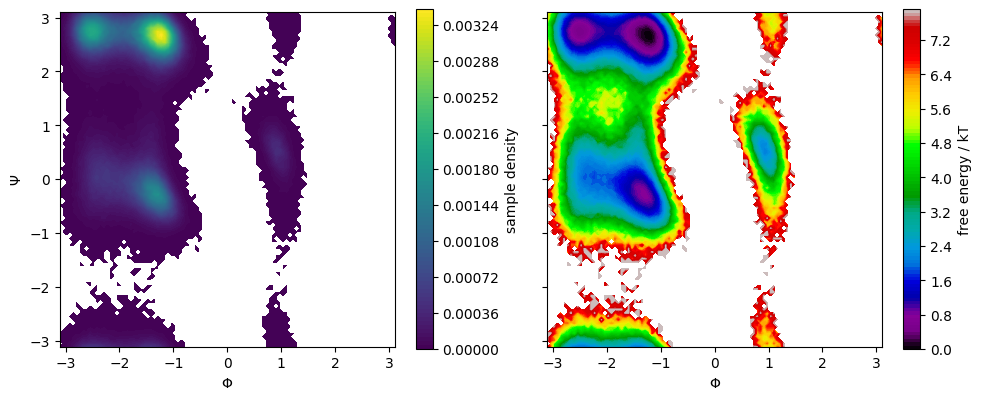

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
# the * operator used in a function call is used to unpack
# the iterable variable into its single elements. 
pyemma.plots.plot_density(*data_concatenated.T, ax=axes[0])
pyemma.plots.plot_free_energy(*data_concatenated.T, ax=axes[1], legacy=False)
for ax in axes.flat:
    ax.set_xlabel('$\Phi$')
    ax.set_aspect('equal')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()

We note that the distribution in backbone torsion space contains several basins that will be assigned to metastable states in follow-up notebooks ([Notebook 05 ➜ 📓](05-pcca-tpt.ipynb), [Notebook 07 ➜ 📓](07-hidden-markov-state-models.ipynb)).
Again, the free energy plot only depicts a pseudo free energy surface of the sampled data and was not re-weighted to equilibrium.

Let us look at a different featurization example and load the positions of all heavy atoms instead.
We create a new featurizer object and use its `add_selection()` method to request the positions of a given selection of atoms.
For this selection, we can use the `select_Heavy()` method which returns the indices of all heavy atoms.

Again, we load the data into memory and show what we loaded using the `describe()` method:

In [16]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_selection(feat.select_Heavy())

data = pyemma.coordinates.load(files, features=feat)

feat.describe()

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/3 [00:00<?, ?it/s]

['ATOM:ACE 1 CH3 1 x',
 'ATOM:ACE 1 CH3 1 y',
 'ATOM:ACE 1 CH3 1 z',
 'ATOM:ACE 1 C 4 x',
 'ATOM:ACE 1 C 4 y',
 'ATOM:ACE 1 C 4 z',
 'ATOM:ACE 1 O 5 x',
 'ATOM:ACE 1 O 5 y',
 'ATOM:ACE 1 O 5 z',
 'ATOM:ALA 2 N 6 x',
 'ATOM:ALA 2 N 6 y',
 'ATOM:ALA 2 N 6 z',
 'ATOM:ALA 2 CA 8 x',
 'ATOM:ALA 2 CA 8 y',
 'ATOM:ALA 2 CA 8 z',
 'ATOM:ALA 2 CB 10 x',
 'ATOM:ALA 2 CB 10 y',
 'ATOM:ALA 2 CB 10 z',
 'ATOM:ALA 2 C 14 x',
 'ATOM:ALA 2 C 14 y',
 'ATOM:ALA 2 C 14 z',
 'ATOM:ALA 2 O 15 x',
 'ATOM:ALA 2 O 15 y',
 'ATOM:ALA 2 O 15 z',
 'ATOM:NME 3 N 16 x',
 'ATOM:NME 3 N 16 y',
 'ATOM:NME 3 N 16 z',
 'ATOM:NME 3 C 18 x',
 'ATOM:NME 3 C 18 y',
 'ATOM:NME 3 C 18 z']

⚠️ Please note that PyEMMA has flattened the $x, y$ and $z$ coordinates into an array that will be used for further analysis.

We visualize the distributions of all loaded features:

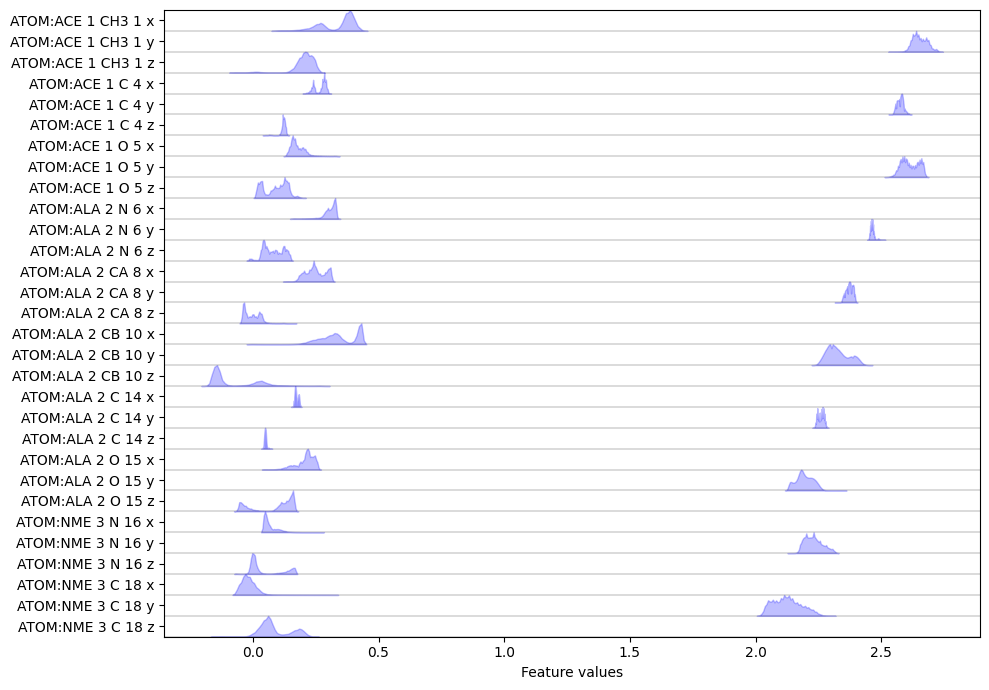

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(np.concatenate(data), feature_labels=feat, ax=ax)
fig.tight_layout()

Again we have a look at the VAMP-2 score of the heavy atom coordinates.

In [18]:
score_heavy_atoms = pyemma.coordinates.vamp(data[:-1], dim=2).score(
        test_data=data[:-1],
        score_method='VAMP2')
print('VAMP2-score backbone torsions: {:f}'.format(score_phi_psi))
print('VAMP2-score xyz: {:f}'.format(score_heavy_atoms))

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)


VAMP2-score backbone torsions: 1.502240
VAMP2-score xyz: 2.471292


As we see, the score for the heavy atom positions is much higher as the one for the $\phi/\psi$ torsion angles.
The feature with a higher score should be favored for further analysis,
because it means that this feature contains more information about slow processes.
If you are already digging deeper into your system of interest,
you can of course restrict the analysis to a set of features you already know describes your processes of interest,
regardless of its VAMP score.

Another featurization that is interesting especially for proteins are pairwise heavy atom distances:

In [19]:
feat = pyemma.coordinates.featurizer(pdb)
heavy_atom_distance_pairs = feat.pairs(feat.select_Heavy())
feat.add_distances(heavy_atom_distance_pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)

feat.describe()

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/3 [00:00<?, ?it/s]

['DIST: ACE 1 CH3 1 - ACE 1 C 4',
 'DIST: ACE 1 CH3 1 - ACE 1 O 5',
 'DIST: ACE 1 CH3 1 - ALA 2 N 6',
 'DIST: ACE 1 CH3 1 - ALA 2 CA 8',
 'DIST: ACE 1 CH3 1 - ALA 2 CB 10',
 'DIST: ACE 1 CH3 1 - ALA 2 C 14',
 'DIST: ACE 1 CH3 1 - ALA 2 O 15',
 'DIST: ACE 1 CH3 1 - NME 3 N 16',
 'DIST: ACE 1 CH3 1 - NME 3 C 18',
 'DIST: ACE 1 C 4 - ACE 1 O 5',
 'DIST: ACE 1 C 4 - ALA 2 N 6',
 'DIST: ACE 1 C 4 - ALA 2 CA 8',
 'DIST: ACE 1 C 4 - ALA 2 CB 10',
 'DIST: ACE 1 C 4 - ALA 2 C 14',
 'DIST: ACE 1 C 4 - ALA 2 O 15',
 'DIST: ACE 1 C 4 - NME 3 N 16',
 'DIST: ACE 1 C 4 - NME 3 C 18',
 'DIST: ACE 1 O 5 - ALA 2 N 6',
 'DIST: ACE 1 O 5 - ALA 2 CA 8',
 'DIST: ACE 1 O 5 - ALA 2 CB 10',
 'DIST: ACE 1 O 5 - ALA 2 C 14',
 'DIST: ACE 1 O 5 - ALA 2 O 15',
 'DIST: ACE 1 O 5 - NME 3 N 16',
 'DIST: ACE 1 O 5 - NME 3 C 18',
 'DIST: ALA 2 N 6 - ALA 2 CA 8',
 'DIST: ALA 2 N 6 - ALA 2 CB 10',
 'DIST: ALA 2 N 6 - ALA 2 C 14',
 'DIST: ALA 2 N 6 - ALA 2 O 15',
 'DIST: ALA 2 N 6 - NME 3 N 16',
 'DIST: ALA 2 N 6 - NME 3 C

Now let us compare the score of heavy atom distance pairs to the other scores.

In [20]:
score_pair_heavy_atom_dists = pyemma.coordinates.vamp(data[:-1], dim=2).score(
    test_data=data[-1],
    score_method='VAMP2')
print('VAMP2-score: {:.2f}'.format(score_pair_heavy_atom_dists))

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)


VAMP2-score: 2.40


Apparently, the heavy atom distance pairs cover an amount of kinetic variance which is comparable to the coordinates themselves.
However we probably would not use much information by using this internal degree of freedom,
while avoiding the need to align our trajectories first.

### `load()` versus `source()`

Using `load()`, we put the full data into memory.
This is possible for all examples in this tutorial.

Many real world applications, though, require more memory than your workstation might provide.
For these cases, you should use the `source()` function:

In [21]:
reader = pyemma.coordinates.source(files, features=feat)
print(reader)

Obtaining file info:   0%|                                | 0/3 [00:00<?, ?it/s]

This function creates a reader, wich allows to stream the underlying data in chunks instead of the full set.
Most of the functions in the `coordinates` sub-package accept data in memory as well as readers.
However, some plotting functions require the data to be in memory.
To load a (sub-sampled) subset into memory, we can use the `get_output()` method with a stride parameter:

In [22]:
data_output = reader.get_output(stride=5)
len(data_output)
print('number of frames in first file: {}'.format(reader.trajectory_length(0)))
print('number of frames after striding: {}'.format(len(data_output[0])))

getting output of FeatureReader:   0%|                    | 0/3 [00:00<?, ?it/s]

number of frames in first file: 250000
number of frames after striding: 50000


We now have loaded every fifth frame into memory.
Again, we can visualize the (concatenated) features with a feature histogram:

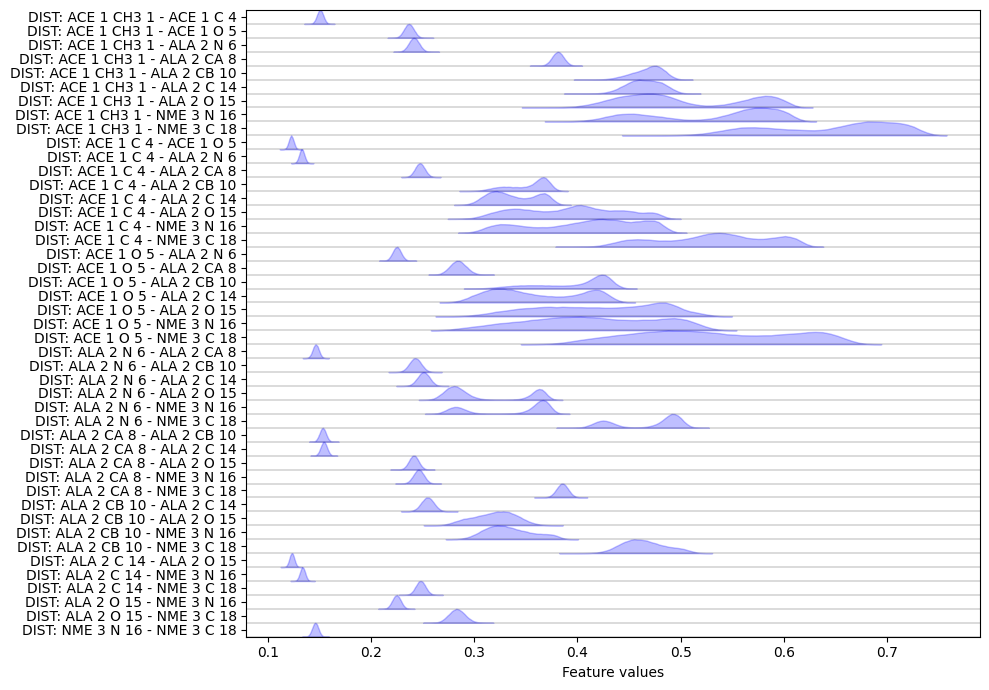

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(
    np.concatenate(data_output), feature_labels=feat, ax=ax)
fig.tight_layout()

### Testing your progress

In the remainder of this notebook, you will find short exercises to test your newly learned skills.
The exercises are announced by the keyword **Exercise** and followed by an incomplete cell.
Missing parts are indicated by
```python
#FIXME
```
Exercise cells come with a button (**Show Solution**) to reveal the solution.

#### Exercise 1: inverse heavy atom distances

Please fix the following code block such that the inverse distances between all heavy atoms are loaded and visualized.

**Hint**: try to use the auto-complete feature on the feat object to gain some insight.
Also take a look at the previous demonstrations.

In [24]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(# FIXME)
feat. #FIXME

data = pyemma.coordinates.load(files, features=feat)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(
    np.concatenate(data), feature_labels=feat, ax=ax)
fig.tight_layout()

SyntaxError: '(' was never closed (1498145127.py, line 2)

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Heavy())
feat.add_inverse_distances(pairs)

data = pyemma.coordinates.load(files, features=feat)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(
    np.concatenate(data), feature_labels=feat, ax=ax)

fig.tight_layout()

#### Excercise 2: compare the inverse distances feature to the previously computed ones

Compute and discuss a cross-validated VAMP score for the inverse pairwise heavy atom distances and plot the result. What do you observe and which feature would you choose for further processing?

In [ ]:
score_inv_dist = pyemma.coordinates. #FIXME

fig, ax = plt.subplots(figsize=(10, 7))
score_mapping = dict(score_heavy_atoms=score_heavy_atoms,
                     score_phi_psi=score_phi_psi,
                     score_pair_heavy_atom_dists=score_pair_heavy_atom_dists,
                     score_inv_dist=score_inv_dist)
lbl = []
for i, (key, value) in enumerate(sorted(score_mapping.items(), key=lambda x: x[1])):
    ax.bar(i, height=value)
    lbl.append(key)
ax.set_xticks(np.arange(0, len(score_mapping), 1))
ax.set_xticklabels(lbl)
fig.tight_layout()

###### Solution

In [ ]:
score_inv_dist = pyemma.coordinates.vamp(
    data[:-1], dim=2).score(test_data=data[-1])

fig, ax = plt.subplots(figsize=(10, 7))
score_mapping = dict(score_heavy_atoms=score_heavy_atoms,
                     score_phi_psi=score_phi_psi,
                     score_pair_heavy_atom_dists=score_pair_heavy_atom_dists,
                     score_inv_dist=score_inv_dist)
lbl = []
for i, (key, value) in enumerate(sorted(score_mapping.items(), key=lambda x: x[1])):
    ax.bar(i, height=value)
    lbl.append(key)
ax.set_xticks(np.arange(0, len(score_mapping), 1))
ax.set_xticklabels(lbl)
fig.tight_layout()

## Case 3: loading `*.xtc` files (pentapeptide)

Once we have obtained the raw data files...

In [ ]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

... and had a quick look at the structure again...

In [ ]:
widget = nglview.show_mdtraj(mdtraj.load(pdb))
p = TrajectoryPlayer(widget)
widget.add_ball_and_stick()
p.spin = True
def stop_spin():
    p.spin = False
    widget.close()
Timer(30, stop_spin).start()
widget

... we can load a selection of features into memory.
Here, we want the $\cos/\sin$ transformations of the backbone and $\chi_1$ sidechain torsions.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(cossin=True, periodic=False)
feat.add_sidechain_torsions(which='chi1', cossin=True, periodic=False)

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

print(feat.describe())

Finally, we visualize the (concatenated) features:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

### Exercises: feature selection and visualization

#### Exercise 3

Complete the following code block to load/visualize the distances between all $\text{C}_\alpha$ carbon atoms.

**Hint**: You might find the `add_distances_ca()` method of the featurizer object helpful.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat. #FIXME

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_distances_ca(periodic=False)

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

#### Exercise 4

Complete the following code block to load/visualize the minimal distances between all residues (excluding first and second neighbors).

**Hint**: You might find the `add_residue_mindist()` method of the featurizer object helpful.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat. #FIXME

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_residue_mindist(periodic=False)

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

#### Exercise 5

Complete the following code block to load/visualize the position of all backbone atoms.

**Hint**: You might find the `select_Backbone()` method of the featurizer object helpful.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat. #FIXME

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_selection(feat.select_Backbone())

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 12))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

#### Exercise 6

Complete the following code block to load/visualize the position of all $\text{C}_\alpha$ atoms.

**Hint**: You might find the `select_Ca()` method of the featurizer object helpful.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat. #FIXME

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_selection(feat.select_Ca())

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

## Wrapping up

In this notebook, we have learned how to load and visualize molecular simulation data with PyEMMA.
In detail, we have used
- `pyemma.coordinates.featurizer()` to define a selection of features we want to extract,
- `pyemma.coordinates.load()` to load data into memory, and
- `pyemma.coordinates.source()` to create a streamed feature reader in case the data does not fit into memory.

After loading the data into memory, we have used
- `pyemma.coordinates.vamp().score()` to score the quality of the features,
- `pyemma.plots.plot_feature_histograms()` to show the distributions of all loaded features,
- `pyemma.plots.plot_density()` to visualize the sample density, and
- `pyemma.plots.plot_free_energy()` to visualize the free energy surface of two selected features.

## References

<a id="cite-vamp-preprint"/><sup><a href=#ref-1>[^]</a></sup>Wu, H. and Noé, F.. 2017. _Variational approach for learning Markov processes from time series data_. [URL](https://arxiv.org/pdf/1707.04659.pdf)

